In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
from scipy import stats
from matplotlib.ticker import PercentFormatter
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import cartopy.feature as cfeature
import requests
import xarray as xr
#look up pickle -save df as binary

In [2]:
#WUS 
Bbox= {'latmax':49.00,'latmin': 31.35,'lonmax': -101.96,'lonmin': -125.07}
latmax = Bbox['latmax']
latmin = Bbox['latmin']
lonmax = Bbox['lonmax']
lonmin = Bbox['lonmin']

#edit time period 
#dates
st = '2011-01-01'
ed = '2020-09-30'

#Issue CSO API observations request and load the results into a GeoDataFrame
params = {
  "bbox": f"{Bbox['lonmin']},{Bbox['latmax']},{Bbox['lonmax']},{Bbox['latmin']}",
  "start_date": st,
  "end_date": ed,
  "format": "geojson",
  "limit": 5000,
}

csodata_resp = requests.get("https://api.communitysnowobs.org/observations", params=params)
csodatajson = csodata_resp.json()

# CSO projection
stn_proj = 'epsg:4326'
gdf = gpd.GeoDataFrame.from_features(csodatajson, crs=stn_proj)

# get cso doy 
gdf['dt'] = pd.to_datetime(gdf['timestamp'], format='%Y-%m-%dT%H:%M:%S')
gdf['dt'] = pd.to_datetime(gdf['dt']).dt.date

datapath = '/nfs/attic/dfh/Aragon2/CSOdata/WUS/'

uapath = '/nfs/attic/dfh/data/UA_SWE/'
uaswe = [uapath+'4km_SWE_Depth_WY2017_v01.nc',uapath+'4km_SWE_Depth_WY2018_v01.nc',
         uapath+'4km_SWE_Depth_WY2019_v01.nc',uapath+'4km_SWE_Depth_WY2020_v01.nc']
ds = xr.merge([ xr.open_dataset(f).sel(lat=slice(latmin, latmax),lon=slice(lonmin,lonmax)) for f in uaswe])
ds

<xarray.Dataset>
Dimensions:   (lat: 424, lon: 553, time: 1461, time_str_len: 11)
Coordinates:
  * time      (time) datetime64[ns] 2016-10-01 2016-10-02 ... 2020-09-30
  * lat       (lat) float32 31.375 31.416666 31.458334 ... 48.958332 49.0
  * lon       (lon) float32 -125.0 -124.958336 ... -102.041664 -102.0
Dimensions without coordinates: time_str_len
Data variables:
    crs       |S1 b''
    time_str  (time_str_len, time) object b'0' b'0' b'0' b'0' ... b'0' b'0' b'0'
    SWE       (time, lat, lon) float32 nan nan nan nan nan ... 0.0 0.0 0.0 0.0
    DEPTH     (time, lat, lon) float32 nan nan nan nan nan ... 0.0 0.0 0.0 0.0

In [10]:
# path = datapath+'WUS_cso.shp'
# gdf = gdf.drop(columns=['dt'])
# gdf.to_file(path)

In [14]:
#get snotel stations
import ulmo
from shapely import geometry as sgeom
from collections import OrderedDict

#function to extract data
def sites_asgdf(ulmo_getsites, crs=stn_proj):
    """ Convert ulmo.cuahsi.wof.get_sites response into a point GeoDataframe
    """
    
    # Note: Found one SNOTEL site that was missing the location key
    sites_df = pd.DataFrame.from_records([
        OrderedDict(code=s['code'], 
        longitude=float(s['location']['longitude']), 
        latitude=float(s['location']['latitude']), 
        name=s['name'], 
        elevation_m=s['elevation_m'])
        for _,s in ulmo_getsites.items()
        if 'location' in s
    ])

    sites_gdf = gpd.GeoDataFrame(
        sites_df, 
        geometry=gpd.points_from_xy(sites_df['longitude'], sites_df['latitude']),
        crs=crs
    )
    return sites_gdf


# Convert the bounding box dictionary to a shapely Polygon geometry using sgeom.box
box_sgeom = sgeom.box(Bbox['lonmin'], Bbox['latmin'], Bbox['lonmax'], Bbox['latmax'])
box_gdf = gpd.GeoDataFrame(geometry=[box_sgeom], crs=stn_proj)


# WaterML/WOF WSDL endpoint url 
wsdlurl = "http://hydroportal.cuahsi.org/Snotel/cuahsi_1_1.asmx?WSDL"

# get dictionary of snotel sites 
sites = ulmo.cuahsi.wof.get_sites(wsdlurl,user_cache=True)

#turn sites as geodataframe 
snotel_gdf = sites_asgdf(sites)

,code,longitude,latitude,name,elevation_m,geometry
0,301_CA_SNTL,-120.791924,41.235828,Adin Mtn,1886.7120361328125,POINT (-120.79192 41.23583)
1,907_UT_SNTL,-112.271179,37.522171,Agua Canyon,2712.719970703125,POINT (-112.27118 37.52217)
2,916_MT_SNTL,-111.959023,45.597229,Albro Lake,2529.840087890625,POINT (-111.95902 45.59723)
3,1267_AK_SNTL,-150.889664,61.749668,Alexander Lake,48.768001556396484,POINT (-150.88966 61.74967)
4,908_WA_SNTL,-121.698471,47.779572,Alpine Meadows,1066.800048828125,POINT (-121.69847 47.77957)
...,...,...,...,...,...,...
925,877_AZ_SNTL,-110.917732,33.812420,Workman Creek,2103.1201171875,POINT (-110.91773 33.81242)
926,1228_UT_SNTL,-111.356850,39.132332,Wrigley Creek,2842.86962890625,POINT (-111.35685 39.13233)
927,1197_UT_SNTL,-112.774948,37.747971,Yankee Reservoir,2649.321533203125,POINT (-112.77495 37.74797)
928,878_WY_SNTL,-109.817749,43.932251,Younts Peak,2545.080078125,POINT (-109.81775 43.93225)


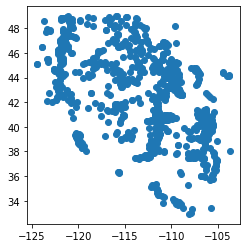

In [17]:
wus_gdf = gpd.sjoin(snotel_gdf, box_gdf, how="inner")
wus_gdf.drop(columns='index_right', inplace=True)
wus_gdf.reset_index(drop=True, inplace=True)
wus_gdf.plot()

In [18]:
path = datapath+'WUS_snotel.shp'
wus_gdf.to_file(path)

Normalized/laundered field name: 'elevation_m' to 'elevation_'


# Depth

In [3]:
bias =[]
for i in range(len(gdf)):
    bias.append(ds.sel(lat=gdf.geometry.y.values[i],
                       lon=gdf.geometry.x.values[i],time=gdf.dt.values[i],
                       method='nearest').DEPTH.values-gdf.depth[i]*10)
    
gdf['bias']=bias

#masked array to remove nans so kde works
mbias = ma.masked_array(bias,np.isnan(bias))

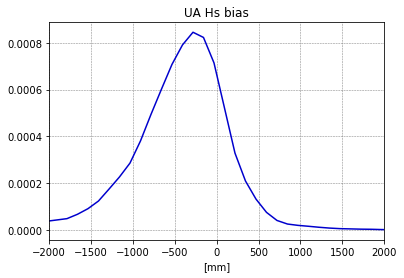

In [8]:
fig, axs = plt.subplots(1)  
data = np.array(mbias.compressed())
kde = stats.gaussian_kde(data)
x = np.linspace(data.min(), data.max(), 100)
p = kde(x)

axs.plot(x,p,color = 'mediumblue')
axs.set_title('UA Hs bias')
axs.set_xlabel('[mm]')
axs.set_xlim([-2000,2000])
axs.grid(linestyle='--', linewidth='0.5', color='grey')

# Figure path
figpath = '/nfs/attic/dfh/Aragon2/CSOfigs/WUS_UA_CSO_depth_bias.pdf'
fig.savefig(figpath, format='pdf', dpi=300)

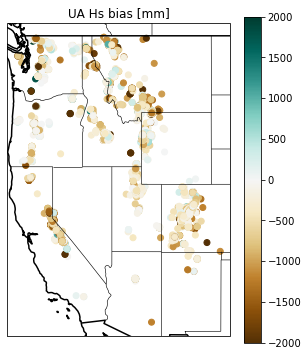

In [6]:
#states
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

bnd = gdf.geometry.bounds
stamen_terrain = cimgt.Stamen('terrain')
dx=1.4
dy=0.4

fig, ax = plt.subplots(
    figsize=(5, 6), subplot_kw={"projection": stamen_terrain.crs}
)
#ax.set_extent([bnd.minx.min() - dx, bnd.maxx.max() + dx, bnd.miny.min() - dy, bnd.maxy.max() + dy])
#ax.add_image(stamen_terrain, 9)
ax.add_feature(states_provinces,edgecolor='k',linewidth=.6)#,linestyle=':')
ax.add_feature(cfeature.BORDERS,edgecolor='k',linewidth=1.5)
ax.add_feature(cfeature.COASTLINE,edgecolor='k',linewidth=1.5)
ax.set_title('UA Hs bias [mm]')

gdf.plot(ax=ax, column='bias', cmap = 'BrBG',legend=True, transform=ccrs.PlateCarree(),vmin=-2000,vmax=2000)

# Figure path
figpath = '/nfs/attic/dfh/Aragon2/CSOfigs/WUS_UA_CSO_depth_bias_map.pdf'
fig.savefig(figpath, format='pdf', dpi=300)

# SWE

In [3]:
gdf['Y'] = pd.DatetimeIndex(gdf['dt']).year
gdf['M'] = pd.DatetimeIndex(gdf['dt']).month
gdf['D'] = pd.DatetimeIndex(gdf['dt']).day
gdf["LON"] = gdf.geometry.x
gdf["LAT"] = gdf.geometry.y
#convert snow depth to mm to input into density function
gdf['H'] = gdf.depth*10

gdf.head()

,geometry,id,author,depth,source,timestamp,elevation,dt,Y,M,D,LON,LAT,H
0,POINT (-119.91036 39.32488),nOYZWIxs,Dan McEvoy,66.0,MountainHub,2020-12-28T21:52:46.258Z,2667.342285,2020-12-28,2020,12,28,-119.910362,39.324877,660.0
1,POINT (-115.77750 47.44760),nTMdJHQy,morgan winchester,100.0,SnowPilot,2020-12-28T21:30:00.000Z,1302.012207,2020-12-28,2020,12,28,-115.777500,47.447600,1000.0
2,POINT (-119.90602 39.32170),eVf/0Zz1,Dan McEvoy,68.0,MountainHub,2020-12-28T21:04:05.184Z,2657.122070,2020-12-28,2020,12,28,-119.906016,39.321699,680.0
3,POINT (-119.02192 37.59414),3rmvBIOb,Rick Ziegler,70.0,SnowPilot,2020-12-28T21:00:00.000Z,2524.103516,2020-12-28,2020,12,28,-119.021920,37.594140,700.0
4,POINT (-120.59184 47.28157),ax+6bnIi,Nina Aragon,54.0,MountainHub,2020-12-28T20:53:51.886Z,1850.030273,2020-12-28,2020,12,28,-120.591844,47.281565,540.0


In [4]:
from Depth2SWE import swe_calc
SWE,DOY = swe_calc(gdf.Y.values,gdf.M.values,gdf.D.values,gdf.H.values,gdf.LAT.values,gdf.LON.values)

gdf['swe']=SWE
gdf['doy']=DOY

In [5]:
swebias =[]
for i in range(len(gdf)):
    swebias.append(ds.sel(lat=gdf.geometry.y.values[i],lon=gdf.geometry.x.values[i],time=gdf.dt.values[i],method='nearest').SWE.values-gdf.swe[i]*10)
    
gdf['swe_bias']=swebias

#masked array to remove nans so kde works
mswebias = ma.masked_array(swebias,np.isnan(swebias))

In [8]:
gdf = gdf.drop(columns=['dt'])

In [9]:
gdf.to_file("UA_cso.geojson", driver='GeoJSON')

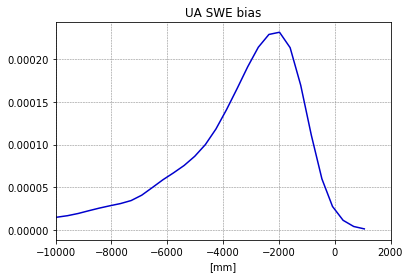

In [15]:
fig, axs = plt.subplots(1)  
data = np.array(mswebias.compressed())
kde = stats.gaussian_kde(data)
x = np.linspace(data.min(), data.max(), 100)
p = kde(x)

axs.plot(x,p,color = 'mediumblue')
axs.set_title('UA SWE bias')
axs.set_xlabel('[mm]')
axs.set_xlim([-10000,2000])
axs.grid(linestyle='--', linewidth='0.5', color='grey')

# Figure path
figpath = '/nfs/attic/dfh/Aragon2/CSOfigs/WUS_UA_CSO_swe_bias.pdf'
fig.savefig(figpath, format='pdf', dpi=300)

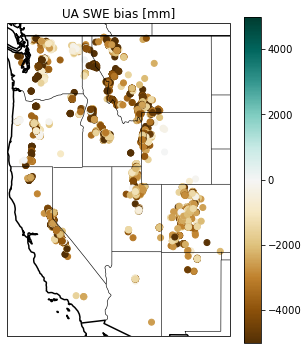

In [13]:
#states
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

bnd = gdf.geometry.bounds
stamen_terrain = cimgt.Stamen('terrain')
dx=1.4
dy=0.4

fig, ax = plt.subplots(
    figsize=(5, 6), subplot_kw={"projection": stamen_terrain.crs}
)
#ax.set_extent([bnd.minx.min() - dx, bnd.maxx.max() + dx, bnd.miny.min() - dy, bnd.maxy.max() + dy])
#ax.add_image(stamen_terrain, 9)
ax.add_feature(states_provinces,edgecolor='k',linewidth=.6)#,linestyle=':')
ax.add_feature(cfeature.BORDERS,edgecolor='k',linewidth=1.5)
ax.add_feature(cfeature.COASTLINE,edgecolor='k',linewidth=1.5)
ax.set_title('UA SWE bias [mm]')

gdf.plot(ax=ax, column='swe_bias', cmap = 'BrBG',legend=True, transform=ccrs.PlateCarree(),vmin=-5000,vmax=5000)

# Figure path
figpath = '/nfs/attic/dfh/Aragon2/CSOfigs/WUS_UA_CSO_swe_bias_map.pdf'
fig.savefig(figpath, format='pdf', dpi=300)